# West Coast Swing Playlist Analytics

Stemming from a one of the fantastic talks at [Westie Wisdom](https://www.super-secret-moves.com/workshops/fuer-trainer-und-organizer) where Flo G. detailed how he went about analyzing his sets using [Spotify's various metrics](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) provided for songs. This is an attempt at continuing down that analytic path to answer some questions:

* **What do various WCS DJ playlists/sets look like?** (from the good to the bad - focusing mainly on the ordered playlists)
* **What music is (un)common in my bubble?** (get spotify connections and map their playlists)

## What do various WCS DJ playlists/sets look like?

### Tools
* Playlist analyzer: https://www.chosic.com/spotify-playlist-analyzer/
* BPM tool: https://www.all8.com/tools/bpm.htm
* Aleš' Event/DJ Playlist Tracker: http://klopca.com/dance/west-coast-swing/music/2024events

I pasted the spotify playlist links into the [playlist analyzer](https://www.chosic.com/spotify-playlist-analyzer/), and downloaded the `.csv` at the bottom

In [11]:
# !pip install polars hvplot altair --upgrade
import polars as pl
import hvplot.polars
import os
import matplotlib as plt
import altair

def adjust_bpm(df_):
    return (df_
             #correctify spotify's bpm guessing
             .with_columns(new_bpm = pl.when(pl.col('BPM') >= 135)
                                        .then(pl.col('BPM')/2)
                                        .when(pl.col('BPM') <= 50)
                                        .then(pl.col('BPM')*2)
                                        .otherwise(pl.col('BPM')),
                           song = pl.col('Song').str.slice(0,18),
                          )
            .sort('#')
           )


df = pl.read_csv('Playlists/good_2024.09.13 Bavarian Open.csv').pipe(adjust_bpm)
df

#,Song,Artist,Popularity,BPM,Genres,Parent Genres,Album,Album Date,Time,Dance,Energy,Acoustic,Instrumental,Happy,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Album Label,Camelot,ISRC,new_bpm,song
i64,str,str,i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,str,str,str,str,f64,str
1,"""Borderline""","""Jordan Rakei""",52,92,"""indie soul, neo r&b""","""R&B""","""Origin (Deluxe Edition)""","""2020-03-13""","""04:15""",55,60,34,0,23,0,0,-7,"""F Major""",4,"""2024-09-14""","""5rcGQIrv6eUIyCBfWga363""","""Ninja Tune""","""7B""","""GBCFB2000077""",92.0,"""Borderline"""
2,"""California King""","""D.B. Ricapito""",29,172,"""""","""""","""California King""","""2018-01-12""","""03:15""",67,52,57,0,72,0,10,-6,"""E Minor""",4,"""2024-09-14""","""180OrhCzFdX7Pyhri6AerI""","""Cheiron Records""","""9A""","""uscgh1812192""",86.0,"""California King"""
3,"""Marvins Room""","""Conor Maynard""",19,171,"""post-teen pop, talent show, uk…","""Pop""","""Vegas Girl""","""2012-07-24""","""03:32""",45,25,95,0,29,0,10,-12,"""F Minor""",3,"""2024-09-14""","""1EjmPUwTvR5UMQ3bPaIVg0""","""Parlophone UK""","""4A""","""GBAYE1200831""",85.5,"""Marvins Room"""
4,"""On Our Knees (feat. R.O)""","""Konoba,R.O""",47,87,"""belgian pop""","""Pop""","""Smoke & Mirrors""","""2017-01-20""","""04:37""",59,34,86,3,27,0,20,-10,"""C♯/D♭ Minor""",4,"""2024-09-14""","""2HCgcgN4PA0xr2ZqtsBpPb""","""Konoba""","""12A""","""BEDY11500005""",87.0,"""On Our Knees (feat"""
5,"""Turn the Lights Down""","""Cavalcade""",0,92,"""""","""""","""Turn the Lights Down""","""2015-06-05""","""03:17""",69,41,44,0,27,0,10,-7,"""E Major""",4,"""2024-09-14""","""3z5Eoxhvou4xGesLoAB36h""","""CRS Music Management""","""12B""","""AUW631100716""",92.0,"""Turn the Lights Do"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
21,"""Testify""","""Robin Thicke""",35,180,"""dance pop, neo soul, pop rap, …","""Pop, R&B, Hip Hop""","""Testify""","""2018-12-12""","""03:20""",67,42,74,0,57,0,10,-9,"""G Major""",4,"""2024-09-14""","""3KUcJryOB8pwkBO3ffzzZD""","""Thicke Music / EMPIRE""","""9B""","""USUYG1230719""",90.0,"""Testify"""
22,"""Let the Rhythm Just""","""The Polish Ambassador,Ayla Ner…",24,98,"""electropop, glitch hop, folktr…","""Hip Hop, Pop, Folk/Acoustic, E…","""Terra Bella""","""2015-08-07""","""05:55""",82,72,31,0,79,0,0,-7,"""D Major""",4,"""2024-09-14""","""0zgkr1a63fSBG9qQq6Yk1W""","""Jumpsuit Records, Inc.""","""10B""","""USDY41551901""",98.0,"""Let the Rhythm Jus"""
23,"""Gone""","""Phlake,Alina Baraz""",37,140,"""danish pop, scandinavian r&b, …","""Pop, R&B""","""Weird Invitations""","""2017-10-06""","""03:34""",51,25,95,0,19,0,10,-10,"""F Minor""",3,"""2024-09-14""","""1bTznoPGxp3ygLTHReQtIh""","""Sony Music Entertainment""","""4A""","""DKADG1700264""",70.0,"""Gone"""


### Graphs! 
(😔 Have to use Matplotlib for Github viewing)

A beginner DJ made some playlists that were too fast (first 3 graphs), but you can see that on the 3rd, with guidance, the set improved around halfway through. Mistakes are great, because you get to improve, and it gives us examples to work with!

The subsequent graphs are sets during events from established DJ's, and you can see the slow pulses and/or gradual slowing of BPM.

/opt/anaconda3/envs/py3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


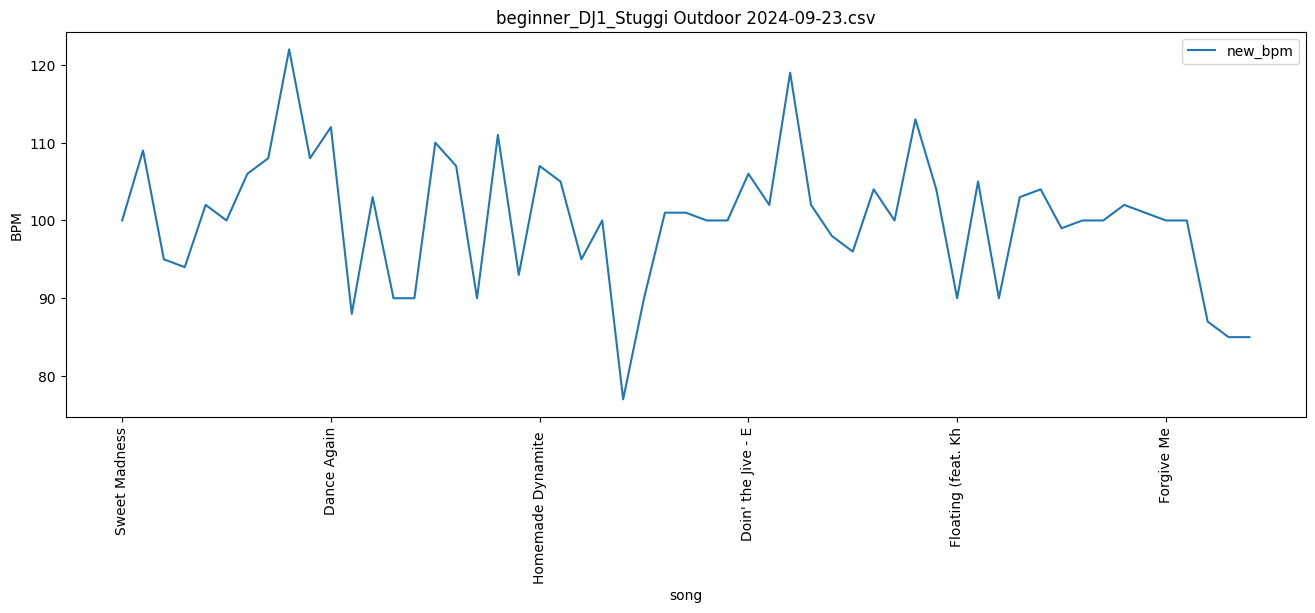

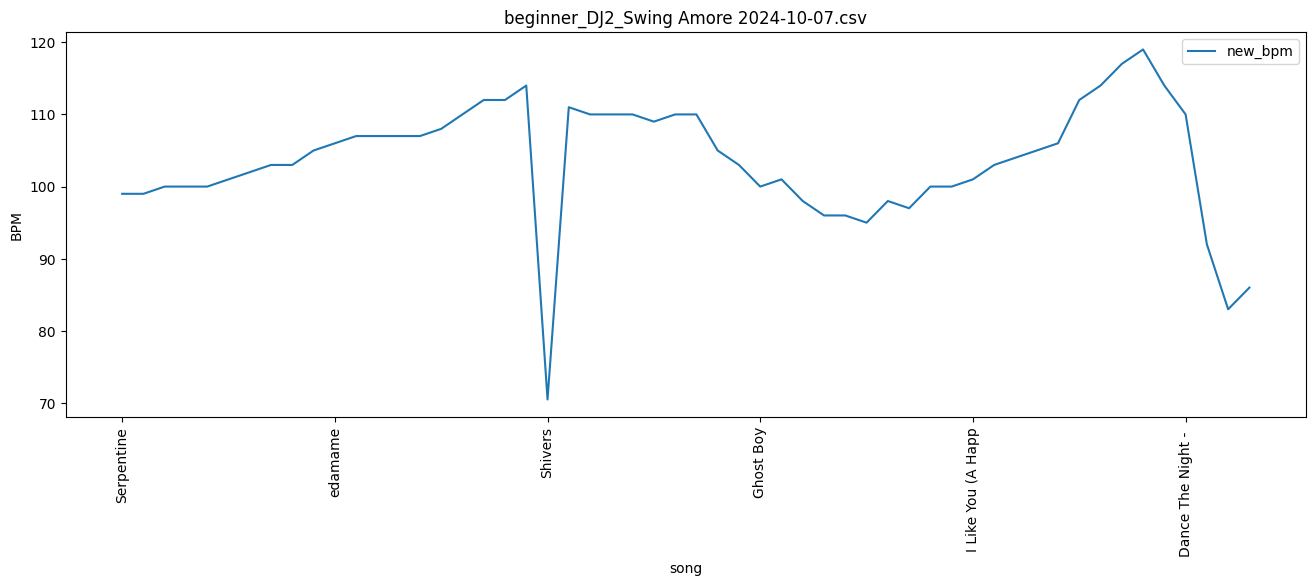

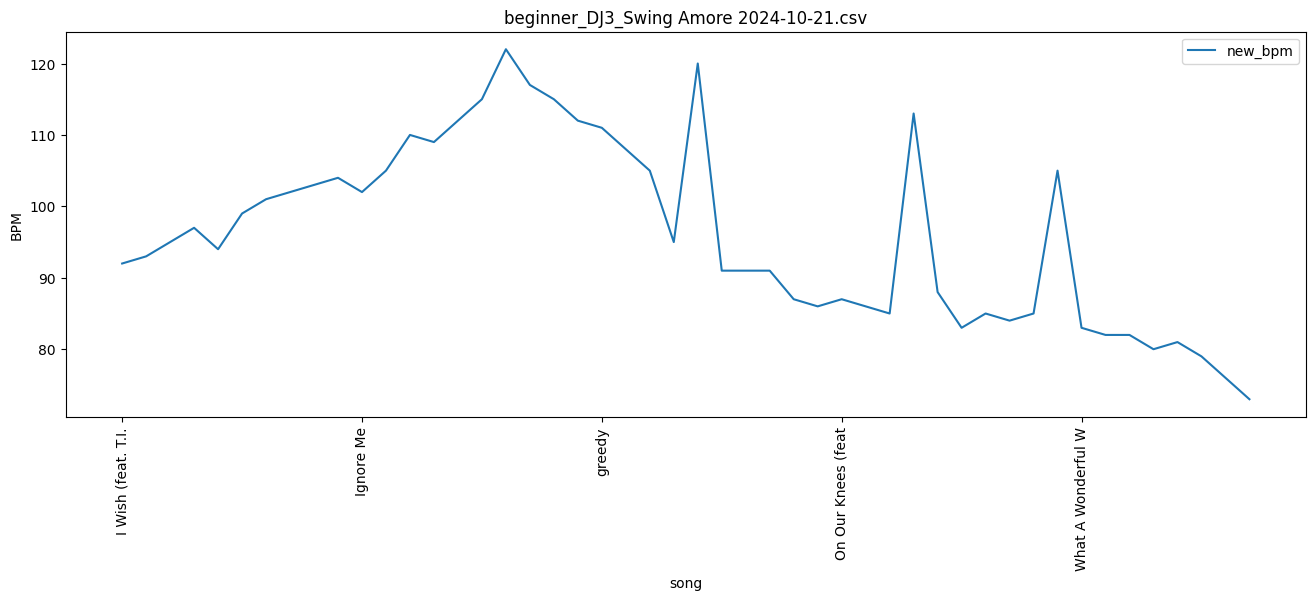

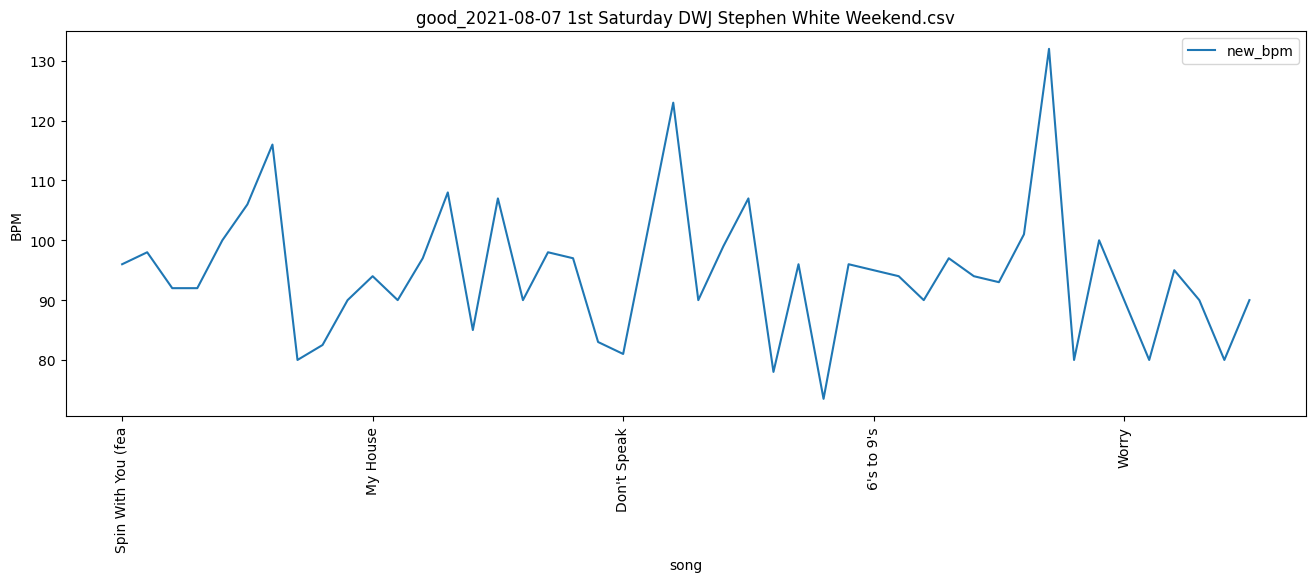

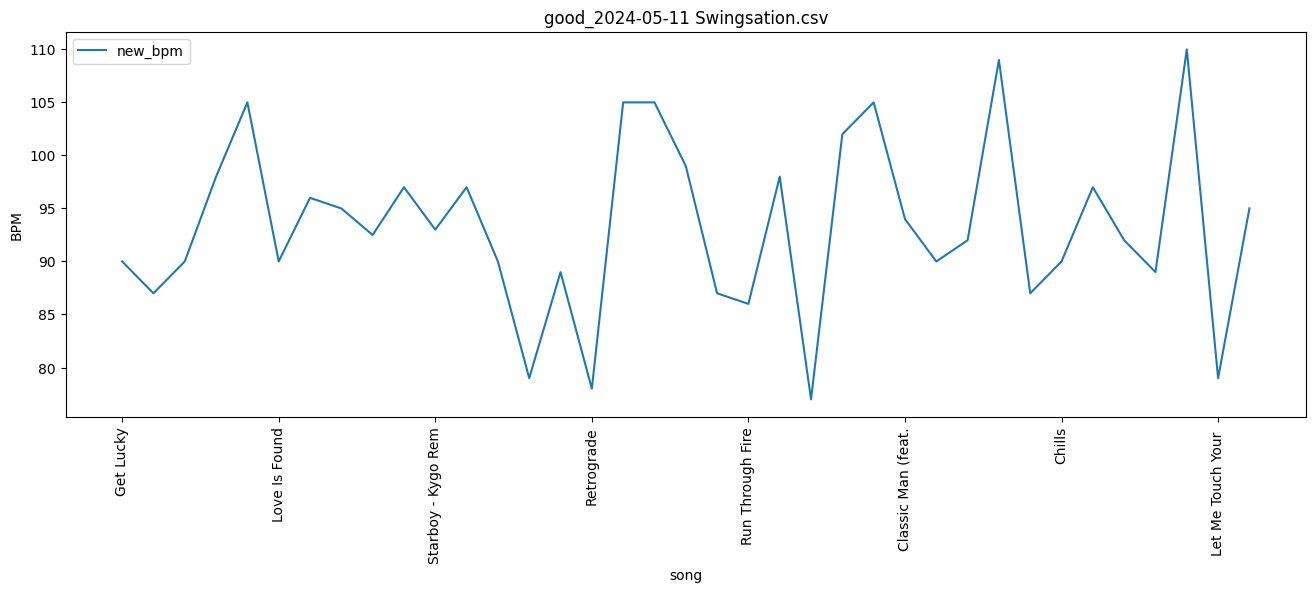

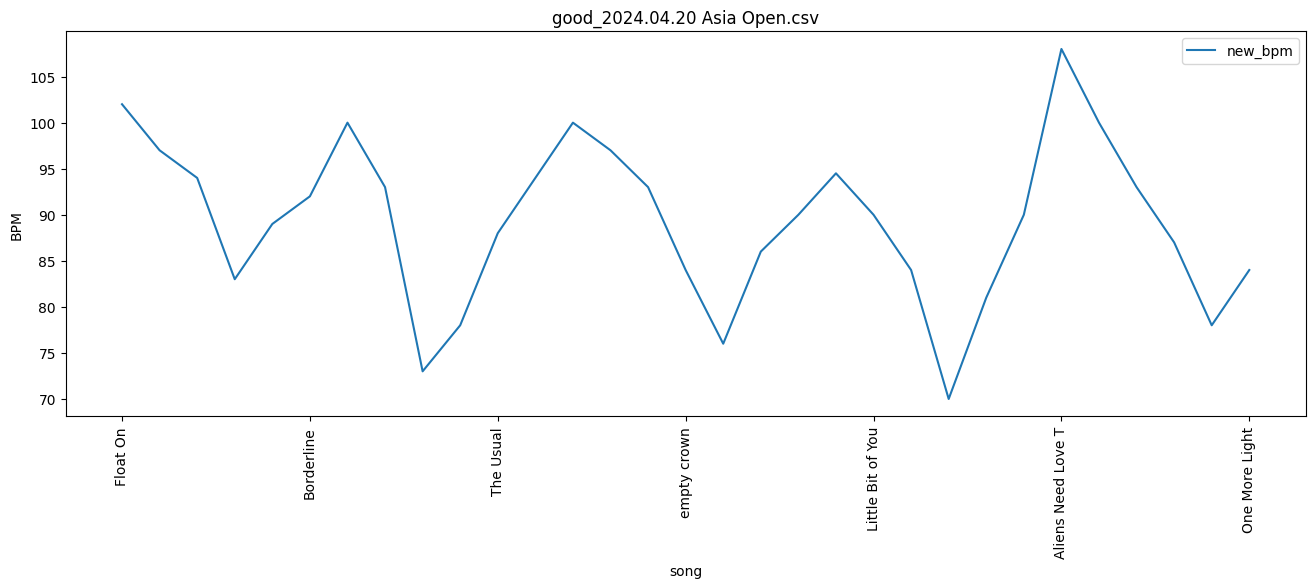

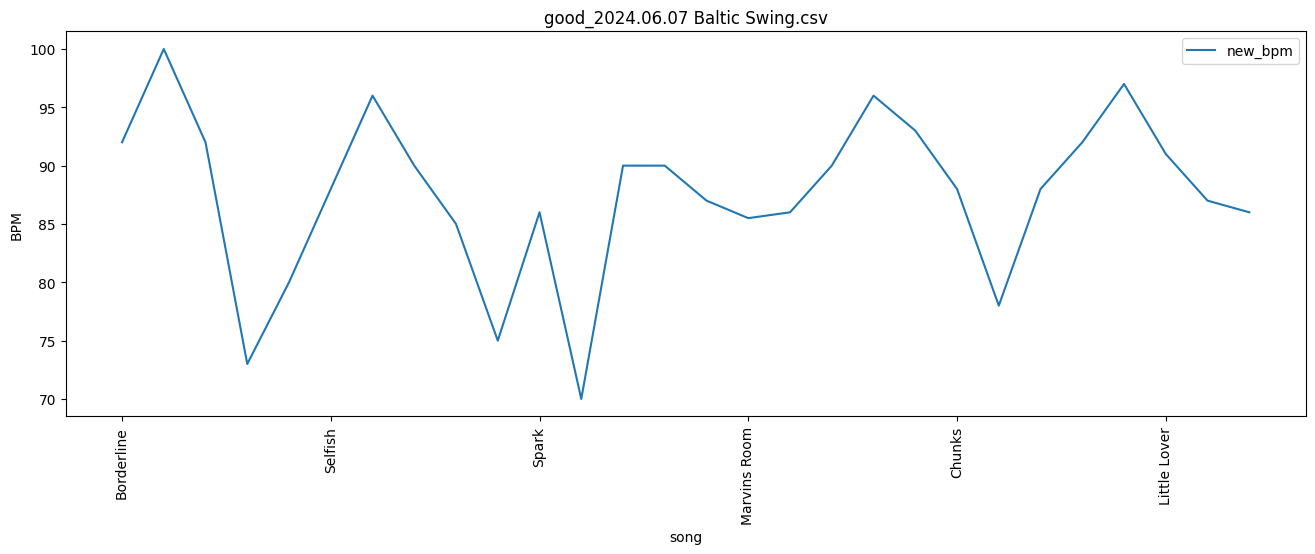

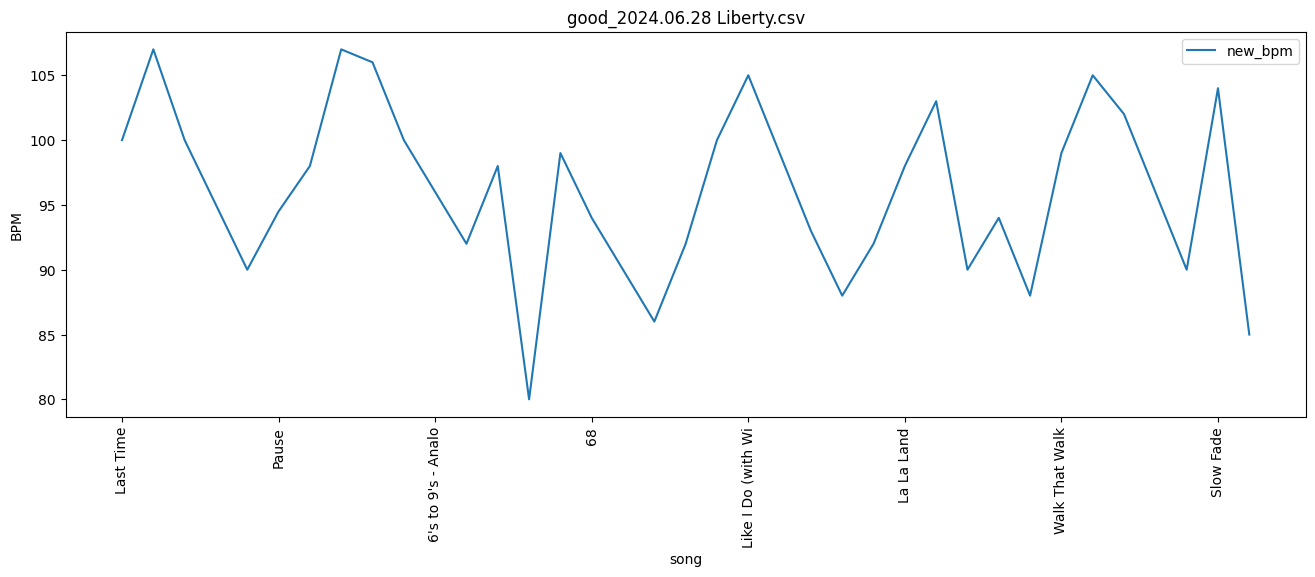

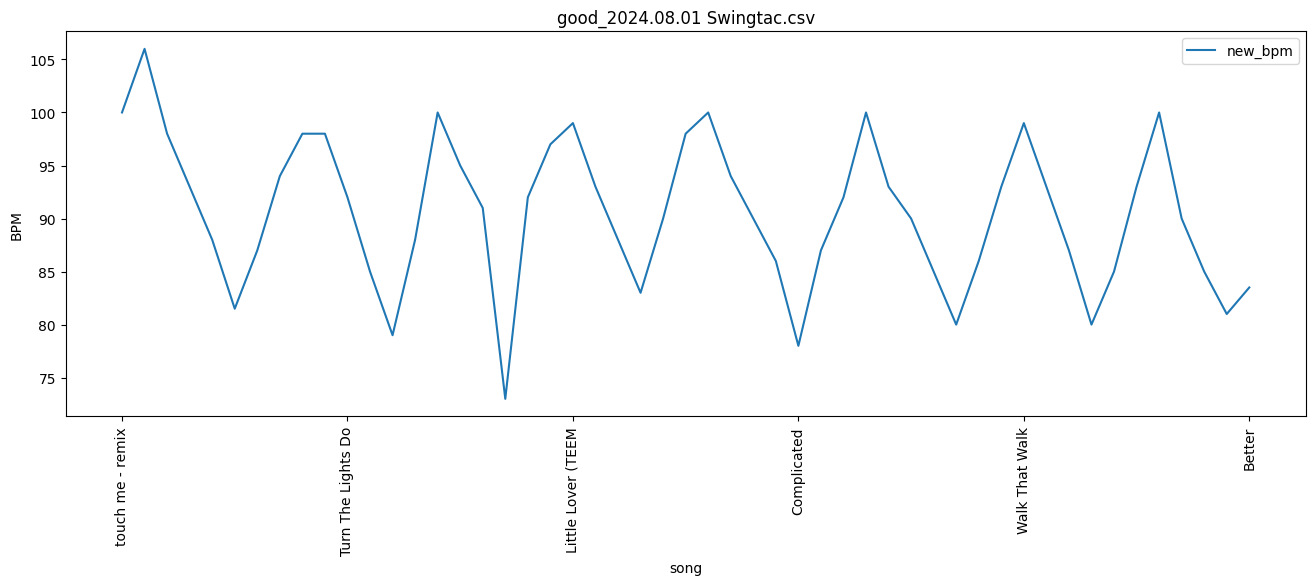

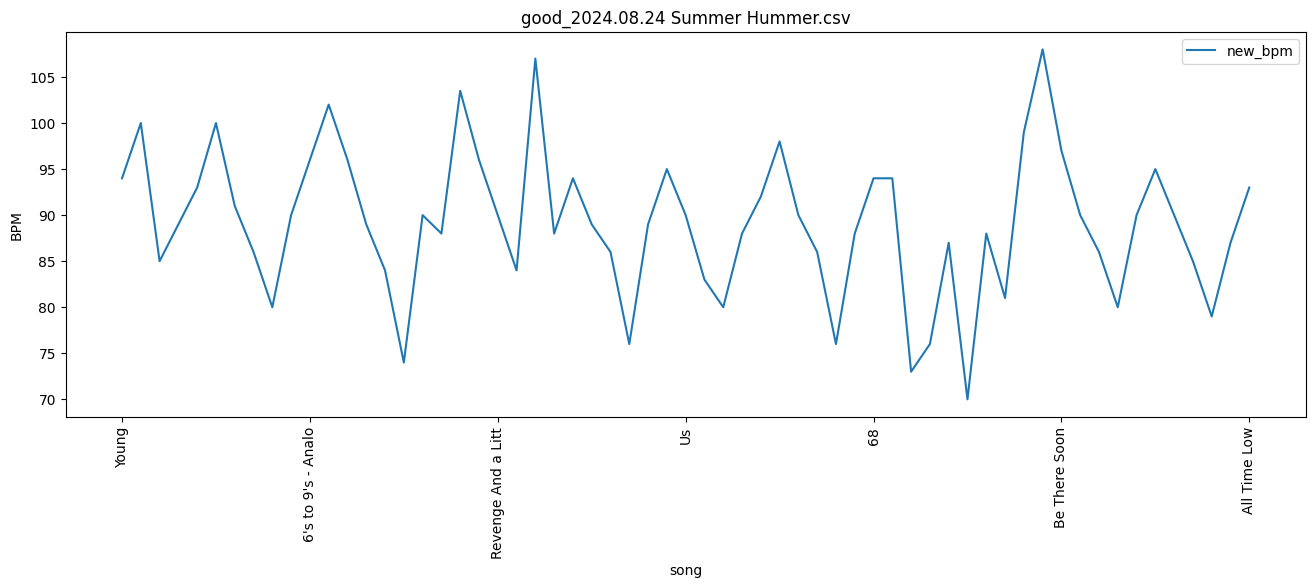

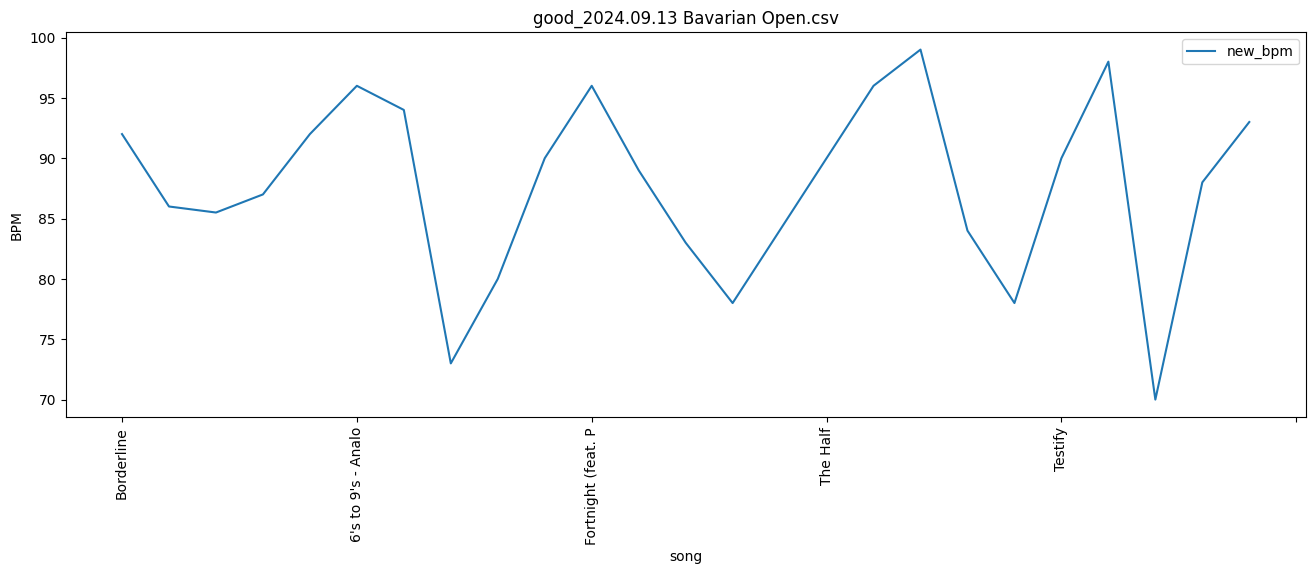

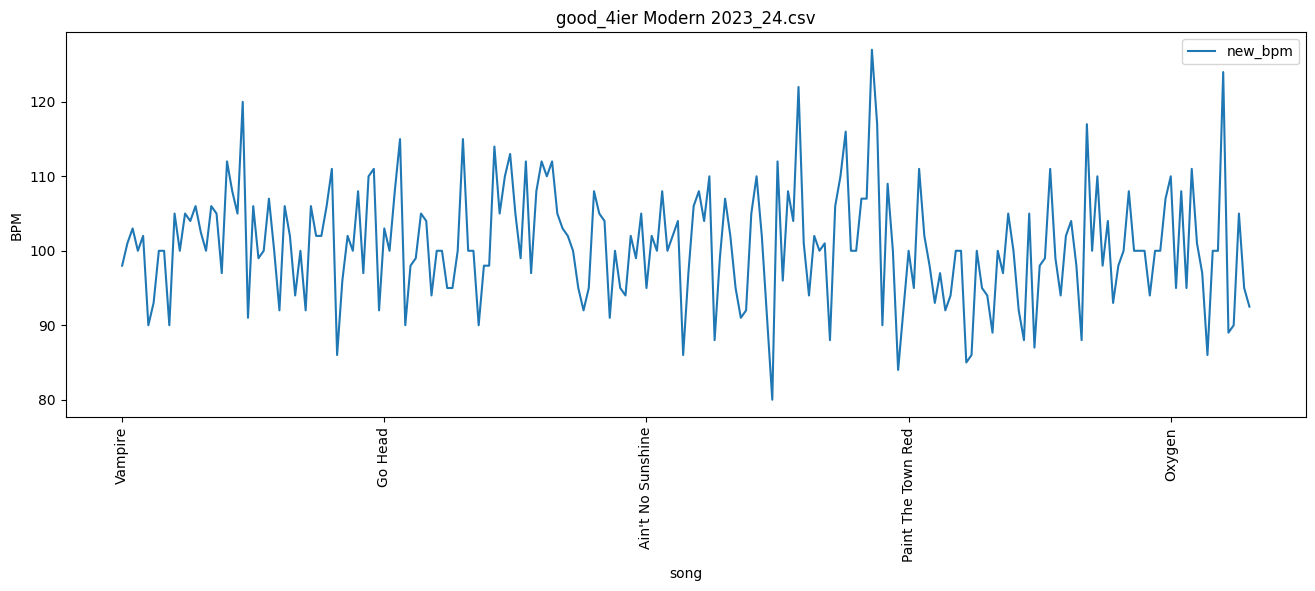

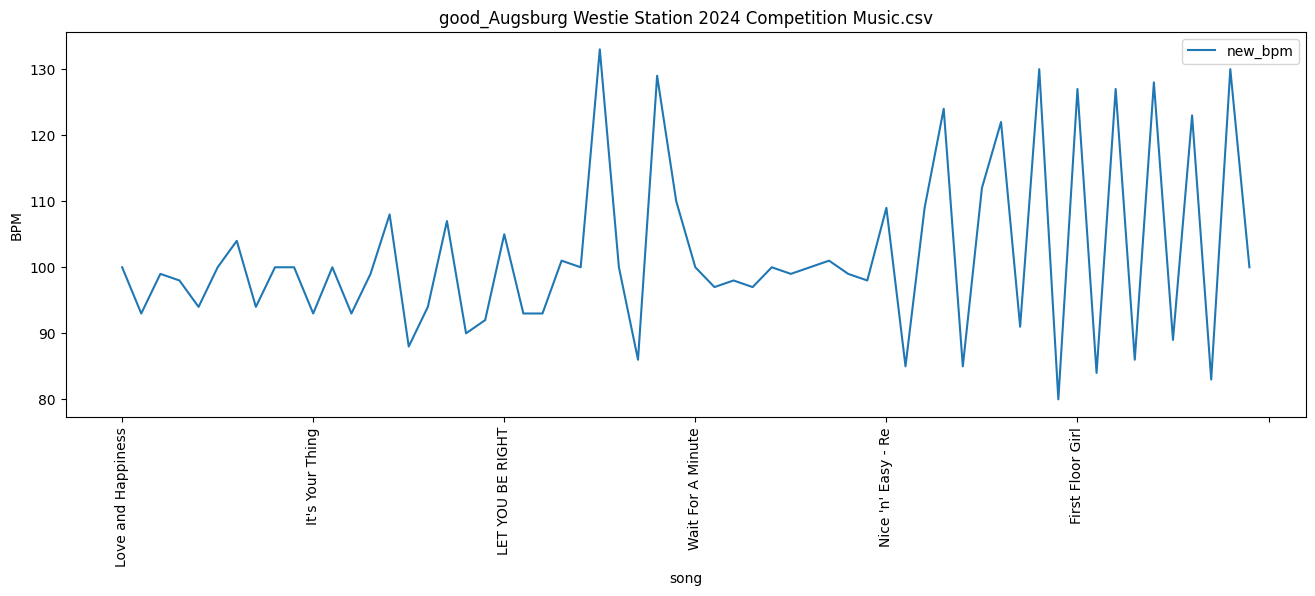

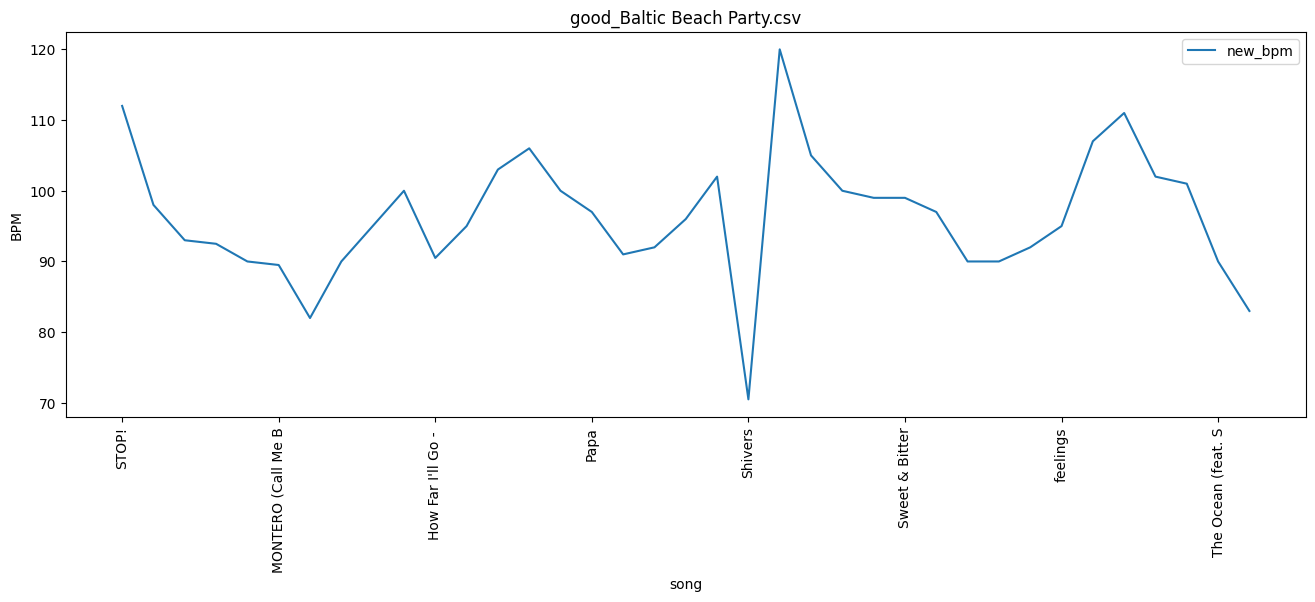

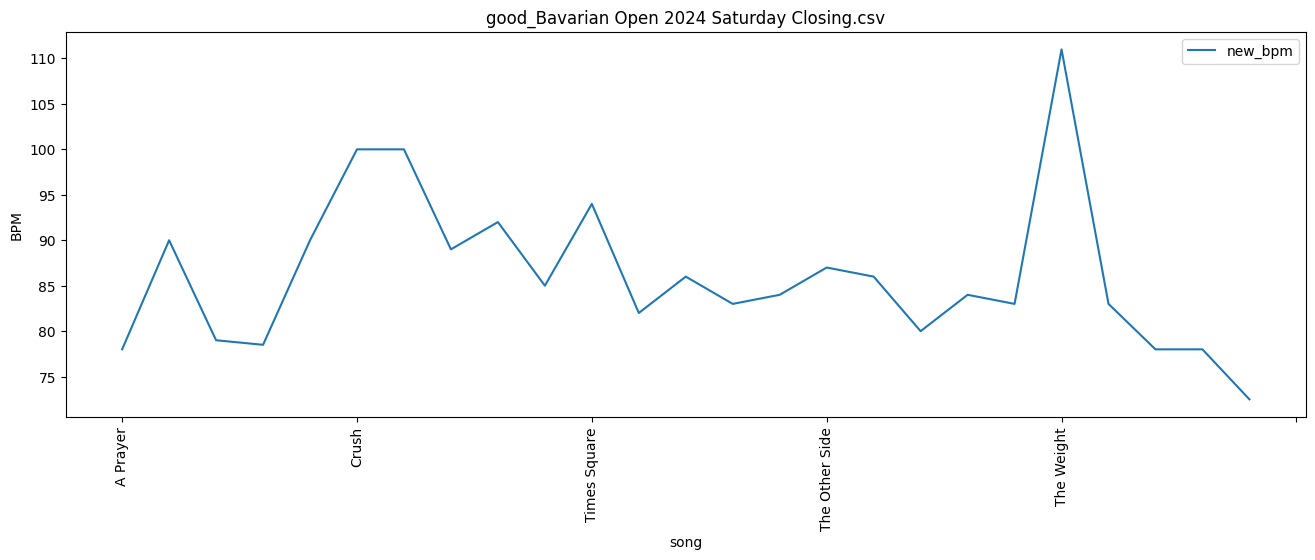

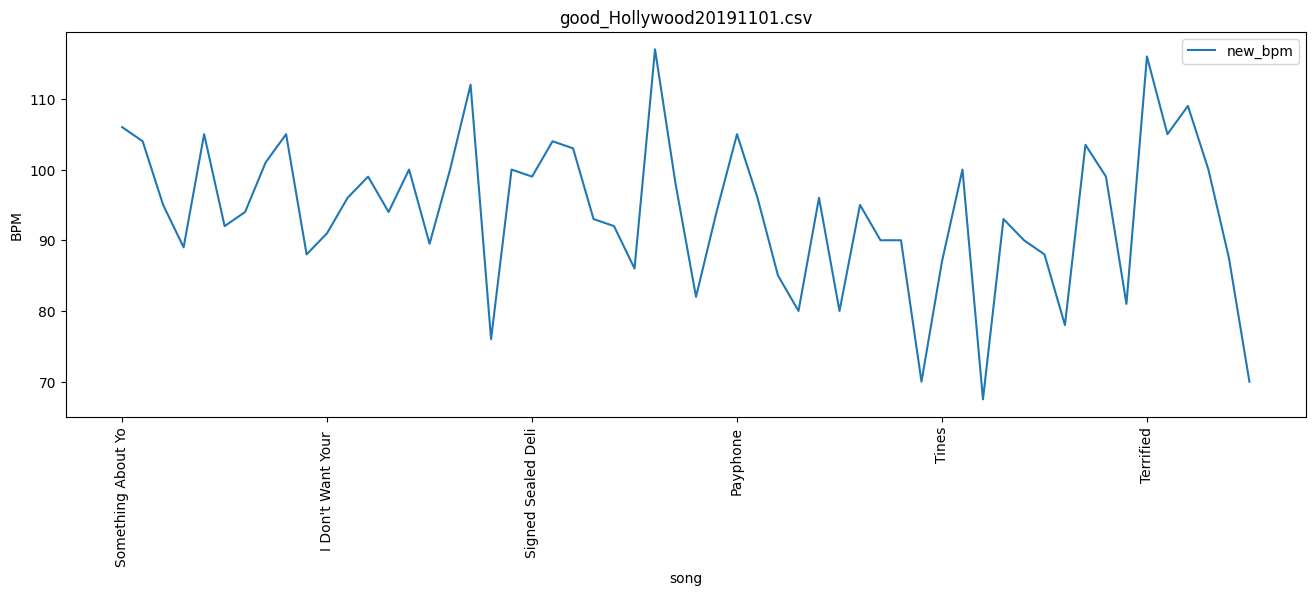

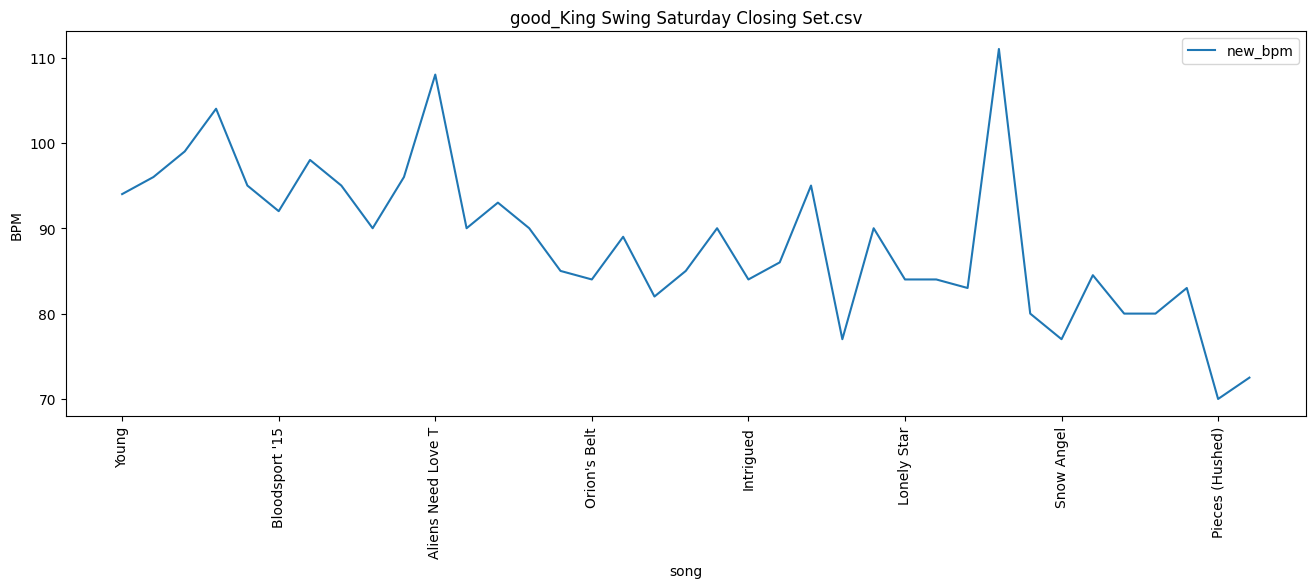

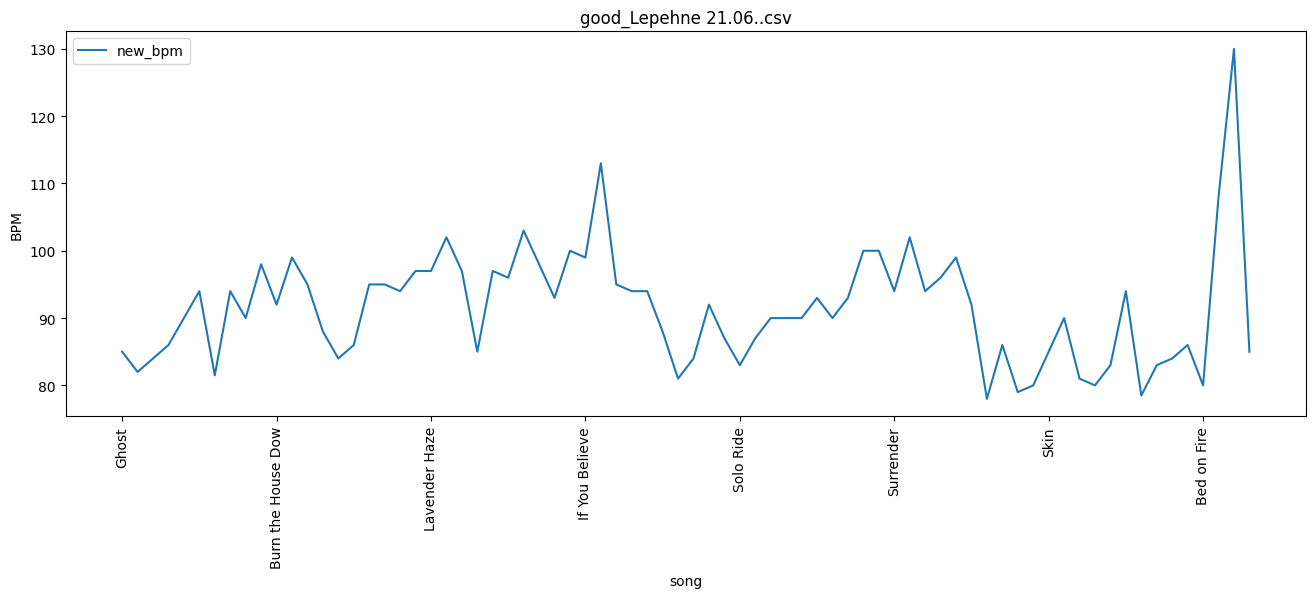

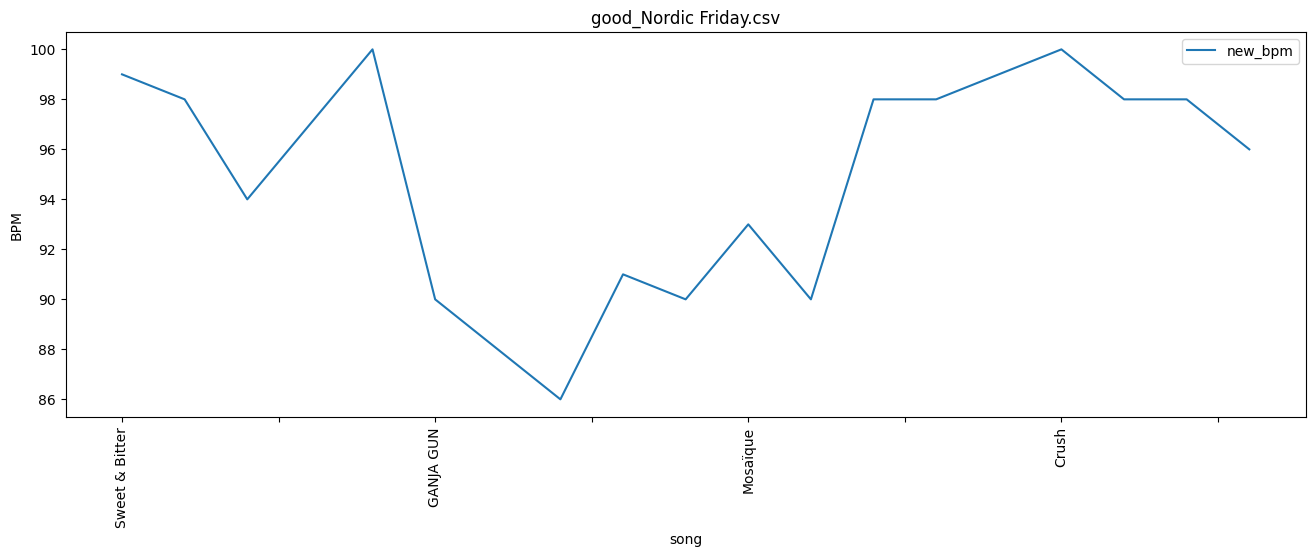

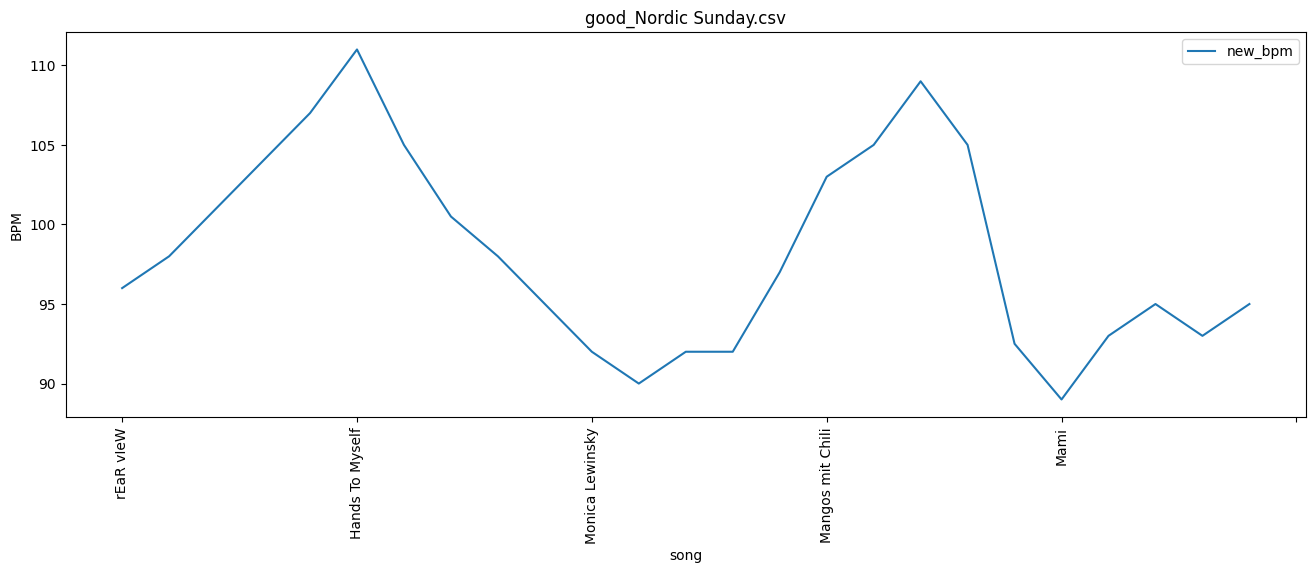

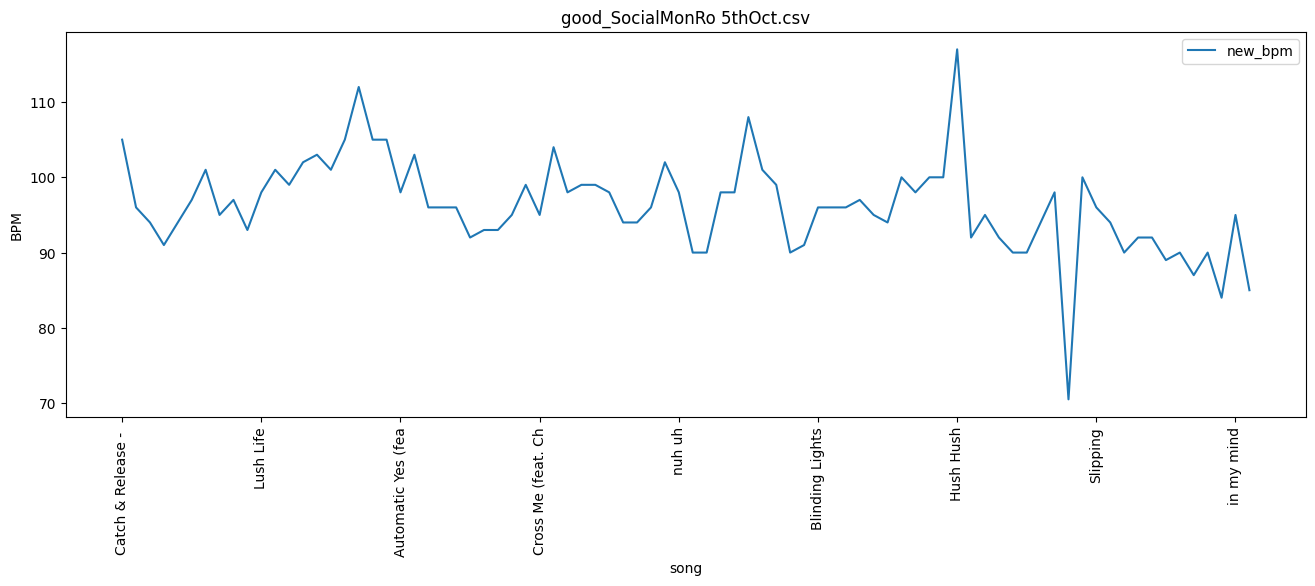

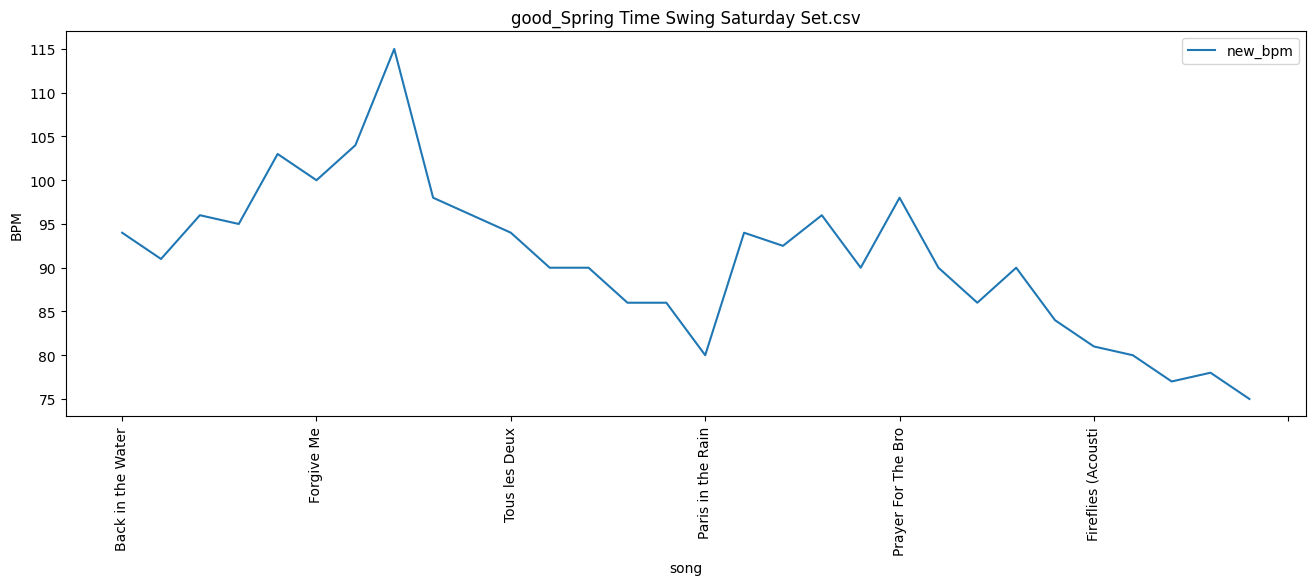

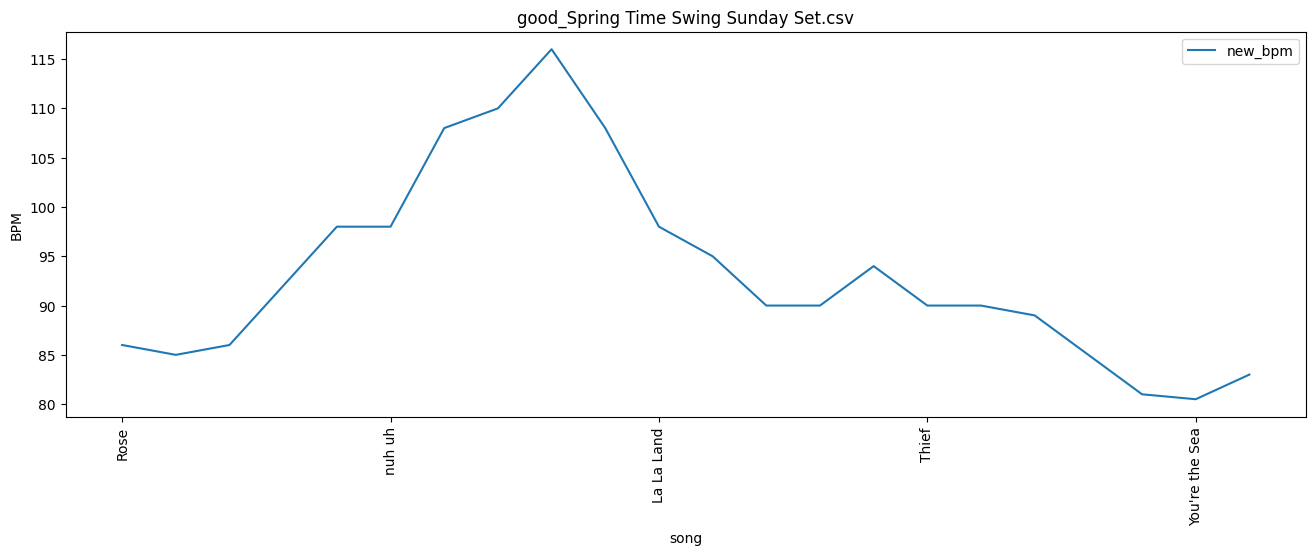

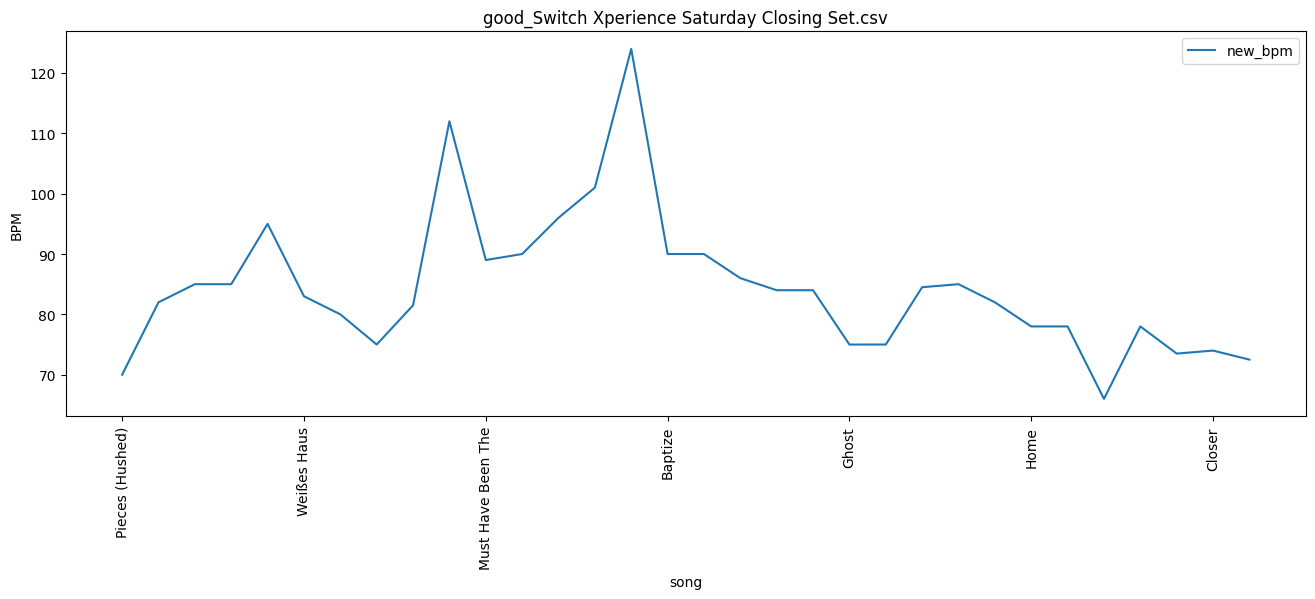

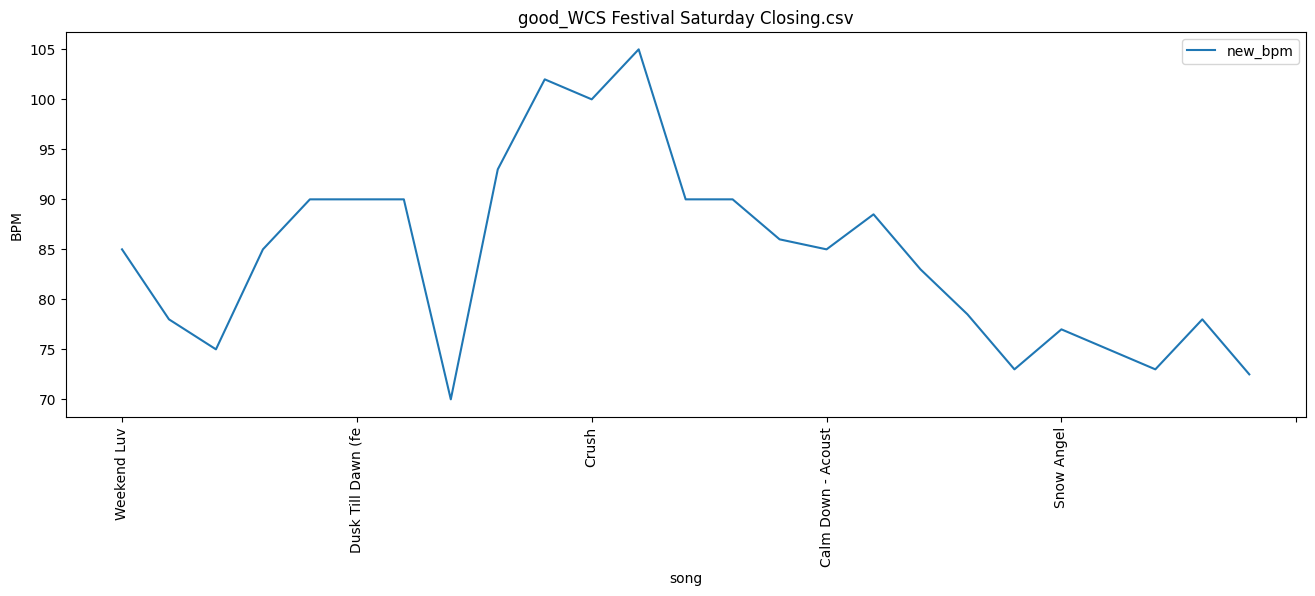

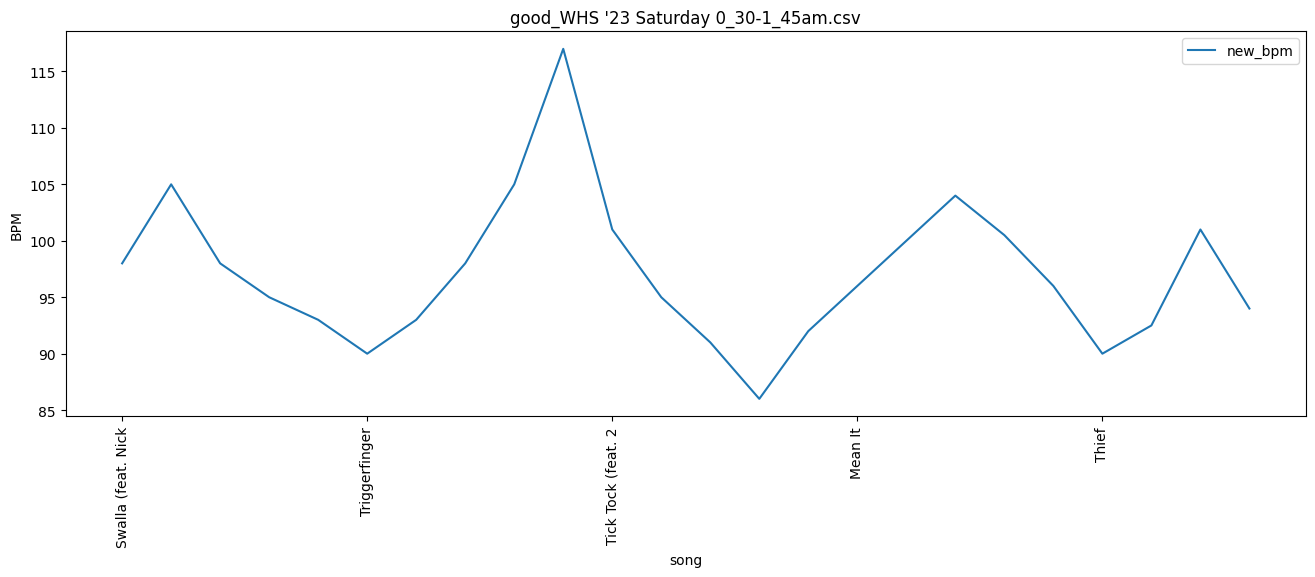

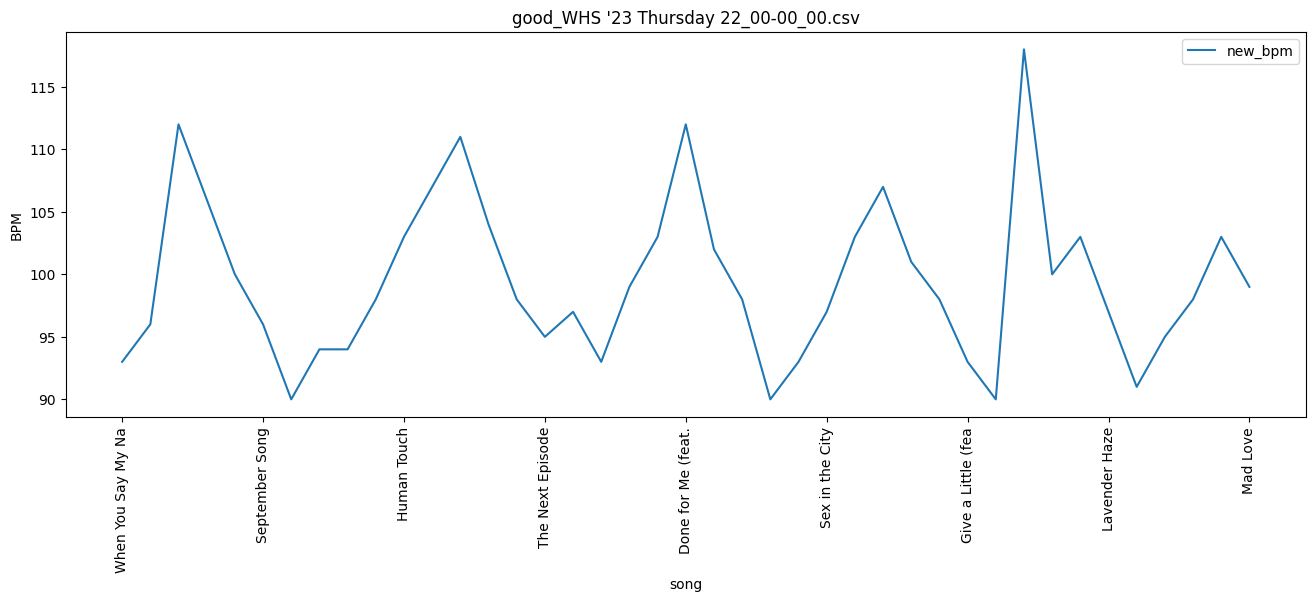

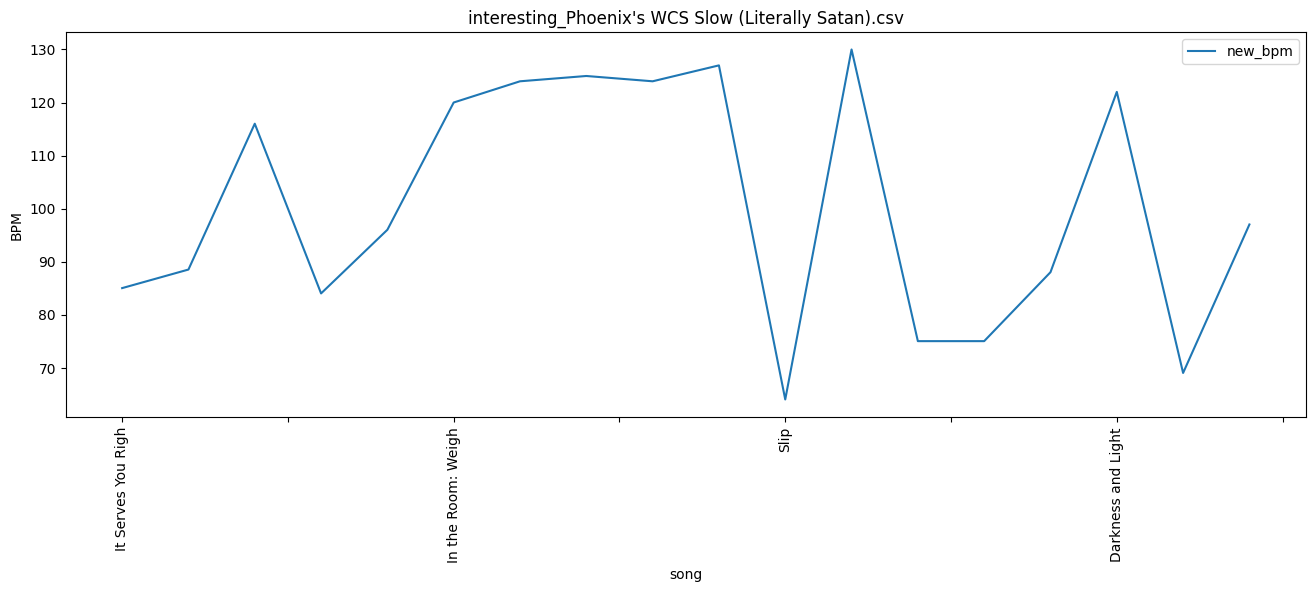

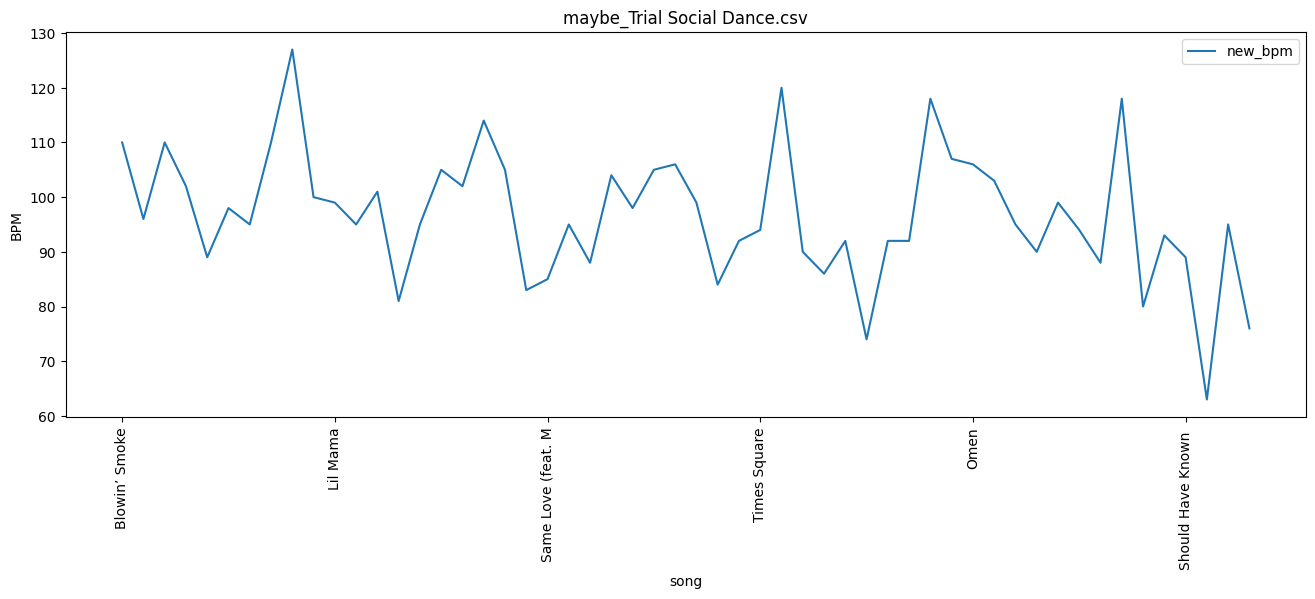

In [12]:
for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i and '.csv' in i:
        (pl.read_csv(f'Playlists/{i}').pipe(adjust_bpm).to_pandas()
          
        #plot things
        ).plot(x='song', 
               y='new_bpm', 
               kind='line',
               title=i,
               figsize=(16, 5), 
               legend=True, 
               rot=90, 
               ylabel='BPM',
              )

### Graphing with `hvplot`

In [ ]:
for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i and '.csv' in i:
        display(pl.read_csv(f'Playlists/{i}').pipe(adjust_bpm)
                 
                #plot things
                .hvplot(x='song', 
                         y=['new_bpm',  
                            # 'Energy'
                           ], 
                         width=1300, 
                         height=500, 
                         stacked=True,
                         legend='top', 
                         title=i,
                        ).opts(xrotation=90)) #rotating song names

## What music is (un)common in my bubble?

## What's the general slope of each playlist?
y = mx + b

In [ ]:
def calculate_slope(xy_pairs):
    # Separate the x and y values from the list of tuples
    x_values = [pair[0] for pair in xy_pairs]
    y_values = [pair[1] for pair in xy_pairs]
    
    n = len(x_values)
    
    # Calculate the sums needed for the slope formula
    sum_x = sum(x_values)
    sum_y = sum(y_values)
    sum_x_y = sum(x * y for x, y in xy_pairs)
    sum_x_squared = sum(x**2 for x in x_values)
    
    # Apply the slope formula
    slope = (n * sum_x_y - sum_x * sum_y) / (n * sum_x_squared - sum_x**2)
    
    return slope

for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i:
        xy_pairs = list(pl.read_csv(f'Playlists/{i}')
                        .pipe(adjust_bpm)
                        .select('#',
                                pl.col('new_bpm'))
                        .iter_rows()
                        )

        # Calculate the slope
        slope = calculate_slope(xy_pairs)
        print(f"{i} \n\t\tSlope: {slope}")
        # break